In [33]:
import math
import numpy as np
import torch.distributed as dist
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data
import yaml
from torch.cuda import amp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import pandas as pd
import test  # import test.py to get mAP after each epoch
from models.yolo import Model
from utils.datasets import create_dataloader

import geopandas


import pickle
import os
from shapely.geometry import Polygon
from pyproj import Transformer
import ast
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None 
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [2]:
def geo_coords(box, x_translation, y_translation, geo_data, center=True):
  """
  Gets coordinates in epsg:4326 format (google maps) of bounding box
  If center, return only coordinate of center of bounding box
  Params:
    Box: [xmin, ymin, xmax, ymax]
  """
  transformer = Transformer.from_crs(geo_data['crs'], 'epsg:4326')
  if center:
    center_x, center_y = (box[2] + box[0])//2 + x_translation, (box[3] + box[1])//2 + y_translation
    new_coords = np.array(geo_data['transform']).reshape((3,3)) @ np.array( [center_x, center_y, 1])

    return transformer.transform(new_coords[0], new_coords[1])

  else:
    new_box = np.array([[x_translation + box[0], y_translation + box[1], 1],
            [x_translation + box[2], y_translation + box[3], 1]])
    new_coords = np.array(geo_data['transform']).reshape((3,3)) @ new_box.T

    return transformer.transform(new_coords[0], new_coords[1])

def get_list_polygon(xs, ys):
  xs, ys = sorted(xs), sorted(ys)
  return [[ys[0], xs[0]], [ys[1], xs[0]], [ys[1], xs[1]], [ys[0], xs[1]]]


In [131]:


def load_targets(annot_path, set_name='val'):
    df = pd.read_csv(os.path.join(annot_path, f'{set_name}.csv')
                     , index_col=0).sort_values(['directory', 'file']).reset_index(drop=True)
    df['width'], df['height'] = 256, 256
    coordinate_list = []
    for file in sorted(os.listdir(os.path.join(annot_path,'labels', set_name))):
        try:
            df_res = pd.read_csv(os.path.join(annot_path, 'labels', set_name, file), header=None, sep=' ')
            num = int(file.replace('.txt', ''))
            md = df.iloc[num]
            md['transform'] = ast.literal_eval(md['transform'].replace("'", '"'))
            for i, row in df_res.iterrows():
                width, height = row[3]* md['width'], row[4] * md['height']
                center_x, center_y = row[1] * md['width'], row[2] * md['height']
                box = [center_x- width//2, center_y - height//2, center_x + width // 2, center_y + width //2]
                xs, ys = geo_coords(box, md['x_offset'], md['y_offset'], md, center=False)
                coordinate_list.append(get_list_polygon(xs, ys))
        except Exception as e:
            pass
    return coordinate_list
    
compute = False
if compute:
    directory = 'testcoolingTowers'
    coord_list = load_targets(f'../datasets/{directory}', )
    import pickle
    with open(f'../datasets/{directory}/val_coords.txt', 'wb') as f:
        pickle.dump(coord_list, f)

In [133]:
df = pd.read_csv('../datasets/testcoolingTowers/val.csv', index_col=0).sort_values(['directory', 'file']).reset_index(drop=True)
df['width'], df['height'] = 256, 256
df.rename(columns={'x_offset': 'x_pos', 'y_offset': 'y_pos'}, inplace=True)
import tqdm
def experiment_evaluate(exp_path, df_metadata, min_thr=0.25):
    coordinate_list=[]
    for file in tqdm.tqdm(os.listdir(os.path.join(exp_path, 'autolabels'))):
        df_res = pd.read_csv(os.path.join(exp_path, 'autolabels', file), header=None, sep=' ')
        num = int(file.replace('.txt', ''))
        md = df_metadata.loc[num]
        md['transform'] = ast.literal_eval(md['transform'].replace("'", '"'))
        df = df_res.loc[df_res[1] > min_thr]
        for i, row in df.iterrows():
            width, height = row[4]* md['width'], row[5] * md['height']
            center_x, center_y = row[2] * md['width'], row[3] * md['height']
            box = [center_x- width//2, center_y - height//2, center_x + width // 2, center_y + width //2]
            xs, ys = geo_coords(box, md['x_pos'], md['y_pos'], md, center=False)
            coordinate_list.append((get_list_polygon(xs, ys),row[1]))
    with open(f'{exp_path}/coords.pkl', 'wb') as f:
        pickle.dump(coordinate_list, f)
    return coordinate_list
preds = experiment_evaluate('runs/exp_6times/', df)

100%|██████████| 3048/3048 [00:23<00:00, 128.89it/s]


In [134]:
model_preds = {}
with open('runs/exp_6times//coords.pkl', 'rb') as f:
    preds = pickle.load(f)
confidences = [p[1] for p in preds]
polygons_preds = [Polygon(p[0]) for p in preds]
model_preds['yolo_6times'] = geopandas.GeoDataFrame(confidences, geometry=polygons_preds)

with open('runs/exp_3times//coords.pkl', 'rb') as f:
    preds = pickle.load(f)
confidences = [p[1] for p in preds]
polygons_preds = [Polygon(p[0]) for p in preds]
model_preds['yolo_3times'] = geopandas.GeoDataFrame(confidences, geometry=polygons_preds)

with open('../hunt_and_find/results/test/exp9.pkl', 'rb') as f:
    preds = pickle.load(f)
confidences = [p[1] for p in preds]
polygons_preds = [Polygon(p[0]) for p in preds]
model_preds['frcnn_3times'] = geopandas.GeoDataFrame(confidences, geometry=polygons_preds)


In [135]:
with open('../datasets/testcoolingTowers/val_coords.txt', 'rb') as f:
    coord_list = pickle.load(f)

polygon_target = [Polygon(p) for p in coord_list]
gdf_targets = geopandas.GeoDataFrame(geometry=polygon_target)



In [136]:
def get_confidence_evol(gdf_in, gdf_targets, confidences=np.arange(0.1, 1, 0.04)):
    p_ls, r_ls = [], []
    for confidence in confidences:
        gdf_preds = gdf_in[gdf_in[0] > confidence]
        preds_match = geopandas.sjoin(gdf_preds, gdf_targets, how='left', op='intersects').drop_duplicates('geometry')
        target_match = geopandas.sjoin(gdf_preds, gdf_targets, how='right', op='intersects').drop_duplicates('geometry')
        tp = target_match[target_match.index_left.notnull()].drop_duplicates('index_left').shape[0]
        fp = preds_match[preds_match.index_right.isna()].shape[0]
        fn = target_match[target_match.index_left.isna()].shape[0]
        p = tp/(tp+fp) if (tp+fp) > 0 else 1
        r = tp/(tp+fn) if (tp + fn) > 0 else 0
        p_ls.append(p)
        r_ls.append(r)
    
    return p_ls, r_ls

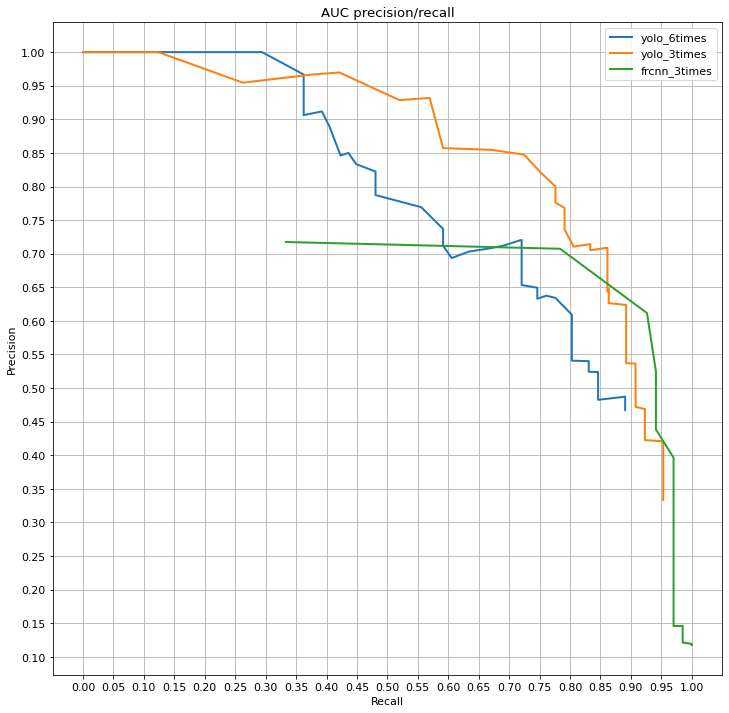

In [148]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('AUC precision/recall')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xticks(np.arange(0,1.01, 0.05))
ax.set_yticks(np.arange(0,1.01, 0.05))
for model in model_preds:
    p_ls, r_ls = get_confidence_evol(model_preds[model], gdf_targets, confidences=np.arange(0.1, 1, 0.01))
    ax.plot(r_ls, p_ls, label=model,linewidth=2 )
ax.legend()
ax.grid()

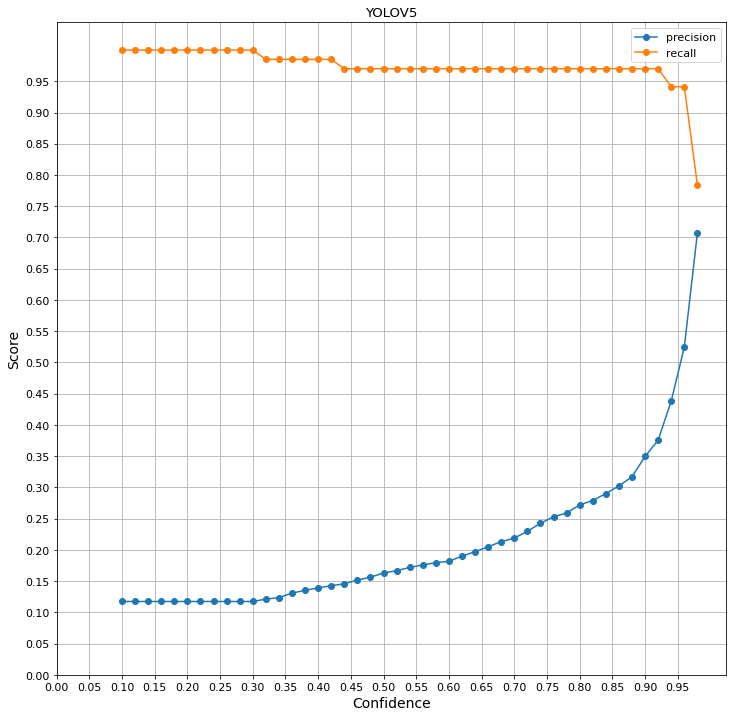

In [142]:
fig, ax = plt.subplots(figsize=(12,12))
confidences=np.arange(0.1, 1, 0.02)
p_ls, r_ls = get_confidence_evol(model_preds['frcnn_3times'], gdf_targets, confidences)
ax.plot(confidences, p_ls, label='precision', marker='o')
ax.plot(confidences, r_ls, label='recall', marker='o')
ax.legend()
ax.set_xlabel('Confidence', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_yticks(np.arange(0,1, 0.05));
ax.set_xticks(np.arange(0,1, 0.05))
ax.grid()

In [ ]:
def plot_confidences(p_ls, r_ls, ax, plotargs, confidences=np.arange(0.1, 0.95, 0.05)):
    ax.plot()
    